# Assignment 2

In [19]:
from __future__ import division, print_function, unicode_literals
import os, sys
# sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/')
# sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/torchvision-0.1.9-py2.7.egg')
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as tnf
from torch.autograd import Variable
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
%matplotlib inline
plt.ion()
# Import other modules if required

resnet_input = 224 #size of resnet18 input images

In [3]:
# Choose your hyper-parameters using validation data
batch_size = 10
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9
use_gpu = False

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [4]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
def build_dataset():
    # Begin
    folders = ("train","test")

    train_classes = {
        'aeroplane' : [],
        'bicycle' : [],
        'bird' : [],
        'boat' : [],
        'bottle' : [],
        'bus' : [],
        'car' : [],
        'cat' : [],
        'chair' : [],
        'cow' : [],
        'diningtable' : [],
        'dog' : [],
        'horse' : [],
        'motorbike' : [],
        'person' : [],
        'pottedplant' : [],
        'sheep' : [],
        'sofa' : [],
        'train' : [],
        'tvmonitor' : []
    }
    test_classes = train_classes


    for dir in folders:
        raw_image = '../datasets/'+dir+'/JPEGImages/'
        anno_image = '../datasets/'+dir+'/Annotations/'
        train_dataset = '../datasets/train/final/'
        for anno_filename in os.listdir(anno_image):
            tree = 	ET.parse(anno_image+anno_filename)
            tmp = anno_filename.split('.')
            img_filename = tmp[0] + '.jpg'
            img = cv2.imread(raw_image+img_filename)
            root = tree.getroot()
            for i,object in enumerate(root.findall('object')):
                class1 = str(object.find('name').text)
                bndbox = object.find('bndbox')
                class1 = str(object[0].text)
                xmin = int(bndbox[0].text)
                ymin = int(bndbox[1].text)
                xmax = int(bndbox[2].text)
                ymax = int(bndbox[3].text)
                crop_img = img[ymin:ymax, xmin:xmax]
                if dir == 'train':
                    cv2.imwrite(train_dataset+class1+'/'+tmp[0]+'_'+str(i)+'.jpg', crop_img)
                    train_classes[class1].append(crop_img)
                # else:
                # 	test_classes[class1].append(crop_img)
            # break


In [10]:
class voc_dataset_train(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.images, self.labels = [], []
        
        if train:
            root_dir = os.path.join(root_dir, 'train/final')
        else:
            root_dir = os.path.join(root_dir, 'test')
        
        label_list = os.listdir(root_dir)
        label_list.sort()
        print (label_list)
        for label in label_list:
            label_dir = os.path.join(root_dir, label)
            label_map = classes.index(label)
            # print(label_map, len(os.listdir(label_dir)))
            for image in os.listdir(label_dir):
                self.images += [os.path.join(label_dir, image)]
                self.labels += [label_map]
        
    def __len__(self):
        # Begin
        return len(self.images)
        
    def __getitem__(self, idx):
        # Begin
        img = Image.open(self.images[idx])
        img = self.transform(img)
        return (img, self.labels[idx])

In [14]:
class voc_dataset_test(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train=False, transform=None):
        # Begin
        self.train = train
        self.transform = transform
        self.annots = []
        self.bndbox_pts = ['xmin','ymin','xmax','ymax']
        
        self.root_dir = os.path.join(root_dir, 'test')
        self.image_dir = os.path.join(self.root_dir, 'JPEGImages')
        self.annot_dir = os.path.join(self.root_dir, 'Annotations')
        
        annot_list = os.listdir(self.annot_dir)
        annot_list.sort()
        for annot_fname in annot_list:
            self.annots += [os.path.join(self.annot_dir, annot_fname)]
        
    def __len__(self):
        # Begin
        return len(self.annots)
        
    def __getitem__(self, idx):
        # Begin
        annot_tree = ET.parse(self.annots[idx])
        root = annot_tree.getroot()
        img = cv2.imread(os.path.join(self.image_dir, str(root.find('filename').text)))
        local_annot = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bndbox = obj.find('bndbox')
            local_annot += [(label, [int(bndbox.find(pt).text) for pt in self.bndbox_pts])]
            
        return (img, local_annot)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [18]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])

dataset_dir = '../datasets/'
train_dataset = voc_dataset_train(root_dir=dataset_dir, train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset_test(root_dir=dataset_dir, train=False, transform=transforms.RandomHorizontalFlip())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# # Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
# print("Train images")
# print(train_labels)
# imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print(str(test_labels))
# imshow(test_images[0])

[u'aeroplane', u'bicycle', u'bird', u'boat', u'bottle', u'bus', u'car', u'cat', u'chair', u'cow', u'diningtable', u'dog', u'horse', u'motorbike', u'person', u'pottedplant', u'sheep', u'sofa', u'train', u'tvmonitor']
[[('dog',), [
 48
[torch.LongTensor of size 1]
, 
 240
[torch.LongTensor of size 1]
, 
 195
[torch.LongTensor of size 1]
, 
 371
[torch.LongTensor of size 1]
]], [('person',), [
 8
[torch.LongTensor of size 1]
, 
 12
[torch.LongTensor of size 1]
, 
 352
[torch.LongTensor of size 1]
, 
 498
[torch.LongTensor of size 1]
]]]


### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [7]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here

In [8]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [9]:
def train():
    # Begin
    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            
            running_loss += loss.data[0]
            
            if (i+1)%10 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        loss_store += [running_loss]

    plt.plot(loss_store)
    plt.title("Sum of Loss over subsequent epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Sum of loss")
    plt.show()

Epoch [1/5], Step [10/1646], Loss: 2.4698
Epoch [1/5], Step [20/1646], Loss: 2.0149
Epoch [1/5], Step [30/1646], Loss: 1.8933
Epoch [1/5], Step [40/1646], Loss: 1.5283
Epoch [1/5], Step [50/1646], Loss: 1.0842
Epoch [1/5], Step [60/1646], Loss: 2.1607
Epoch [1/5], Step [70/1646], Loss: 1.3776
Epoch [1/5], Step [80/1646], Loss: 1.2806
Epoch [1/5], Step [90/1646], Loss: 1.6860
Epoch [1/5], Step [100/1646], Loss: 1.7764
Epoch [1/5], Step [110/1646], Loss: 1.0725
Epoch [1/5], Step [120/1646], Loss: 1.2006
Epoch [1/5], Step [130/1646], Loss: 0.6563
Epoch [1/5], Step [140/1646], Loss: 1.4340
Epoch [1/5], Step [150/1646], Loss: 1.2169
Epoch [1/5], Step [160/1646], Loss: 1.3653
Epoch [1/5], Step [170/1646], Loss: 1.0261
Epoch [1/5], Step [180/1646], Loss: 0.9962
Epoch [1/5], Step [190/1646], Loss: 1.0139
Epoch [1/5], Step [200/1646], Loss: 1.1964
Epoch [1/5], Step [210/1646], Loss: 0.4838
Epoch [1/5], Step [220/1646], Loss: 0.9952
Epoch [1/5], Step [230/1646], Loss: 1.4261
Epoch [1/5], Step [2

Epoch [2/5], Step [270/1646], Loss: 0.5551
Epoch [2/5], Step [280/1646], Loss: 0.0989
Epoch [2/5], Step [290/1646], Loss: 0.2406
Epoch [2/5], Step [300/1646], Loss: 0.4813
Epoch [2/5], Step [310/1646], Loss: 0.0515
Epoch [2/5], Step [320/1646], Loss: 0.3101
Epoch [2/5], Step [330/1646], Loss: 0.5970
Epoch [2/5], Step [340/1646], Loss: 0.3329
Epoch [2/5], Step [350/1646], Loss: 0.1439
Epoch [2/5], Step [360/1646], Loss: 0.5210
Epoch [2/5], Step [370/1646], Loss: 0.1432
Epoch [2/5], Step [380/1646], Loss: 0.3005
Epoch [2/5], Step [390/1646], Loss: 0.0949
Epoch [2/5], Step [400/1646], Loss: 0.3097
Epoch [2/5], Step [410/1646], Loss: 0.6737
Epoch [2/5], Step [420/1646], Loss: 0.4232
Epoch [2/5], Step [430/1646], Loss: 0.6555
Epoch [2/5], Step [440/1646], Loss: 0.1793
Epoch [2/5], Step [450/1646], Loss: 0.6443
Epoch [2/5], Step [460/1646], Loss: 0.6361
Epoch [2/5], Step [470/1646], Loss: 0.5162
Epoch [2/5], Step [480/1646], Loss: 0.9541
Epoch [2/5], Step [490/1646], Loss: 0.7669
Epoch [2/5]

Epoch [3/5], Step [530/1646], Loss: 0.1784
Epoch [3/5], Step [540/1646], Loss: 0.3352
Epoch [3/5], Step [550/1646], Loss: 0.2995
Epoch [3/5], Step [560/1646], Loss: 0.9170
Epoch [3/5], Step [570/1646], Loss: 0.4536
Epoch [3/5], Step [580/1646], Loss: 0.4958
Epoch [3/5], Step [590/1646], Loss: 0.3420
Epoch [3/5], Step [600/1646], Loss: 0.3269
Epoch [3/5], Step [610/1646], Loss: 0.1751
Epoch [3/5], Step [620/1646], Loss: 0.4253
Epoch [3/5], Step [630/1646], Loss: 0.2990
Epoch [3/5], Step [640/1646], Loss: 1.1210
Epoch [3/5], Step [650/1646], Loss: 0.0202
Epoch [3/5], Step [660/1646], Loss: 0.3370
Epoch [3/5], Step [670/1646], Loss: 0.9314
Epoch [3/5], Step [680/1646], Loss: 0.3392
Epoch [3/5], Step [690/1646], Loss: 0.2925
Epoch [3/5], Step [700/1646], Loss: 0.3817
Epoch [3/5], Step [710/1646], Loss: 0.3176
Epoch [3/5], Step [720/1646], Loss: 0.3885
Epoch [3/5], Step [730/1646], Loss: 0.0829
Epoch [3/5], Step [740/1646], Loss: 0.1932
Epoch [3/5], Step [750/1646], Loss: 0.1430
Epoch [3/5]

Epoch [4/5], Step [790/1646], Loss: 0.5168
Epoch [4/5], Step [800/1646], Loss: 0.3201
Epoch [4/5], Step [810/1646], Loss: 0.0411
Epoch [4/5], Step [820/1646], Loss: 0.0164
Epoch [4/5], Step [830/1646], Loss: 0.3245
Epoch [4/5], Step [840/1646], Loss: 0.3043
Epoch [4/5], Step [850/1646], Loss: 0.0829
Epoch [4/5], Step [860/1646], Loss: 0.3927
Epoch [4/5], Step [870/1646], Loss: 0.9157
Epoch [4/5], Step [880/1646], Loss: 0.3303
Epoch [4/5], Step [890/1646], Loss: 0.0751
Epoch [4/5], Step [900/1646], Loss: 0.0534
Epoch [4/5], Step [910/1646], Loss: 0.0189
Epoch [4/5], Step [920/1646], Loss: 0.1399
Epoch [4/5], Step [930/1646], Loss: 0.0706
Epoch [4/5], Step [940/1646], Loss: 0.8518
Epoch [4/5], Step [950/1646], Loss: 0.2910
Epoch [4/5], Step [960/1646], Loss: 0.2709
Epoch [4/5], Step [970/1646], Loss: 0.2780
Epoch [4/5], Step [980/1646], Loss: 0.0467
Epoch [4/5], Step [990/1646], Loss: 0.0092
Epoch [4/5], Step [1000/1646], Loss: 0.1439
Epoch [4/5], Step [1010/1646], Loss: 0.0360
Epoch [4/

Epoch [5/5], Step [1050/1646], Loss: 0.2525
Epoch [5/5], Step [1060/1646], Loss: 0.0960
Epoch [5/5], Step [1070/1646], Loss: 0.6714
Epoch [5/5], Step [1080/1646], Loss: 0.9826
Epoch [5/5], Step [1090/1646], Loss: 0.0173
Epoch [5/5], Step [1100/1646], Loss: 0.1394
Epoch [5/5], Step [1110/1646], Loss: 0.4217
Epoch [5/5], Step [1120/1646], Loss: 0.3618
Epoch [5/5], Step [1130/1646], Loss: 0.3011
Epoch [5/5], Step [1140/1646], Loss: 0.1020
Epoch [5/5], Step [1150/1646], Loss: 0.2073
Epoch [5/5], Step [1160/1646], Loss: 0.0297
Epoch [5/5], Step [1170/1646], Loss: 0.0425
Epoch [5/5], Step [1180/1646], Loss: 0.1689
Epoch [5/5], Step [1190/1646], Loss: 0.6390
Epoch [5/5], Step [1200/1646], Loss: 0.3350
Epoch [5/5], Step [1210/1646], Loss: 0.0492
Epoch [5/5], Step [1220/1646], Loss: 0.0235
Epoch [5/5], Step [1230/1646], Loss: 0.0228
Epoch [5/5], Step [1240/1646], Loss: 0.3815
Epoch [5/5], Step [1250/1646], Loss: 0.3369
Epoch [5/5], Step [1260/1646], Loss: 0.1084
Epoch [5/5], Step [1270/1646], L

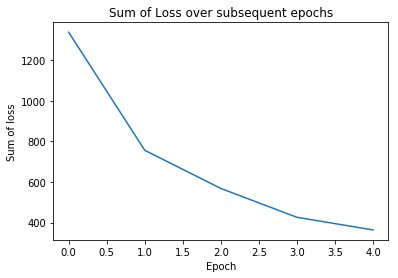

CPU times: user 14h 52min 1s, sys: 31min 48s, total: 15h 23min 49s
Wall time: 9h 34min 24s


In [10]:
%time train()

In [18]:
torch.save(resnet18.state_dict(), 'resnet18_model.pkl')

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [7]:
def sliding_window(image, stepSize=15, windowSize=(45,45)):
    # Begin
    arr = []
    for y in range(0, image.shape[0]-windowSize[0], stepSize):
        for x in range(0, image.shape[1]-windowSize[1], stepSize):
            arr.append((x, y, x + windowSize[0]-1, y + windowSize[1]-1, 
                        image[y:y + windowSize[1], x:x + windowSize[0]]))
    return arr

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [17]:
def non_maximum_supression(boxes, threshold=0.3):
    # Begin
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in xrange(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > threshold:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

Test the trained model on the test dataset.

In [ ]:
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)